## Chassisml Example Notebooks
Welcome to the examples section for [Chassis.ml](https://chassis.ml), which contains notebooks that leverage Chassisml to auto-containerize models built using the most common machine learning frameworks. 

**NOTE:** Chassisml provides two key functionalities: 
1. Create a Docker container from your model code and push that container image to a Docker registry. This is the default behavior.
2. Should you pass valid Modzy credentials as optional parameters, Chassisml will take the container and upload it directly to the Modzy environment you specify. You will notice most of these notebooks deploy the model to one of the Modzy internal development environments.   

Can't find the framework you are looking for or need help? Fork this repository and open a PR, we're always interested in growing this example bank! 

The primary maintainers of Chassis also actively monitor our [Discord Server](https://discord.gg/tdfXFY2y), so feel free to join and ask any questions you might have. We'll be there to respond and help out promptly. 

In [1]:
import chassisml
import cv2
import torch
import getpass
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision import transforms

## Enter credentials
Dockerhub creds and Modzy API Key

In [2]:
dockerhub_user = getpass.getpass('docker hub username')
dockerhub_pass = getpass.getpass('docker hub password')
modzy_api_key = getpass.getpass('modzy api key')

docker hub username········
docker hub password········
modzy api key········


## Prepare model and data transform
Initialize anything here that should persist across inference runs

In [96]:
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])    

sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

device = 'cpu'

## Write process function

* Must take bytes as input
* Preprocess bytes, run inference, postprocess model output, return results

In [97]:
def process(input_bytes):
    
    # preprocess
    decoded = cv2.imdecode(np.frombuffer(input_bytes, np.uint8), -1)
    img_t = transform(decoded)
    batch_t = torch.unsqueeze(img_t, 0).to(device)
    
    # run inference
    predictions = model(batch_t)["out"]
    
    # postprocess
    normalized_masks = torch.nn.functional.softmax(predictions, dim=1)
    
    # limit to dog class due to mask size 
    dog_mask = normalized_masks[0][sem_class_to_idx["dog"]]
    inference_result = {
        "classSegmentationMasks": [
            {"class": "dog", "mask": dog_mask.detach().cpu().numpy().tolist()}
        ]
    }

    structured_output = {
        "data": {
            "result": inference_result,
            "explanation": None,
            "drift": None,
        }
    }
    
    return structured_output

## Initialize Chassis Client
We'll use this to interact with the Chassis service

In [98]:
chassis_client = chassisml.ChassisClient("http://localhost:5000")

## Create and test Chassis model
* Requires `process_fn` defined above

In [ ]:
# create Chassis model
chassis_model = chassis_client.create_model(process_fn=process)

# test Chassis model (can pass filepath, bufferedreader, bytes, or text here):
sample_filepath = './data/dog.jpg'
results = chassis_model.test(sample_filepath)
print(results)

In [ ]:
# test environment and model within Chassis service, must pass filepath here:
test_env_result = chassis_model.test_env(sample_filepath)
print(test_env_result)

## Publish model to Modzy
Need to provide model name, model version, Dockerhub credentials, and required Modzy info

In [101]:
MODZY_URL = "https://integration.modzy.engineering/api"

response = chassis_model.publish(
    model_name="PyTorch Deeplab ResNet50 Semantic Segmentation",
    model_version="0.0.1",
    registry_user=dockerhub_user,
    registry_pass=dockerhub_pass,
    modzy_sample_input_path=sample_filepath,
    modzy_api_key=modzy_api_key,
    modzy_url=MODZY_URL
)

job_id = response.get('job_id')
final_status = chassis_client.block_until_complete(job_id)

Starting build job... Ok!


In [102]:
if chassis_client.get_job_status(job_id)["result"] is not None:
    print("New model URL: {}".format(chassis_client.get_job_status(job_id)["result"]["container_url"]))
else:
    print("Chassis job failed \n\n {}".format(chassis_client.get_job_status(job_id)))

New model URL: https://integration.modzy.engineering/models/aa9kusedyg/0.0.1


## Run sample job
Submit inference job to our newly-deploy model running on Modzy

In [ ]:
from modzy import ApiClient

client = ApiClient(base_url='https://integration.modzy.engineering/api', api_key=modzy_api_key)

input_name = final_status['result']['inputs'][0]['name']
model_id = final_status['result'].get("model").get("modelId")
model_version = final_status['result'].get("version")

inference_job = client.jobs.submit_file(model_id, model_version, {input_name: sample_filepath})
inference_job_result = client.results.block_until_complete(inference_job, timeout=None)
inference_job_results_json = inference_job_result.get_first_outputs()['results.json']
print(inference_job_results_json)

In [104]:
def display_segmentation(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

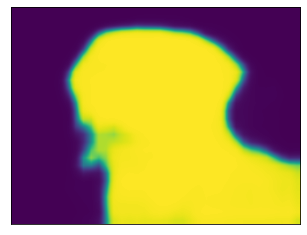

In [105]:
display_segmentation(np.asarray(inference_job_results_json["data"]["result"]["classSegmentationMasks"][0]['mask']))